In [29]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
run_all_models = True

cpu


## Load The Data

Using the NYU Depth Dataset V2, [available here](https://cs.nyu.edu/~fergus/datasets/nyu_depth_v2.html#raw_parts).

Data download steps:
1. Download the data (matlab file) from the link provided. I chose the 'labeled dataset', not the 'raw dataset'
2. Open the file in Matlab
3. Save all of the images individually in a new images folder, mine being data/images
4. Save all of the labels individually in a new labels folder, mine being data/labels


In [2]:
class NYUDepthV2Dataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images_folder = os.path.join(root, 'images')
        self.depths_folder = os.path.join(root, 'labels')
        self.image_filenames = sorted(os.listdir(self.images_folder))
        self.depth_filenames = sorted(os.listdir(self.depths_folder))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_folder, self.image_filenames[idx])
        depth_path = os.path.join(self.depths_folder, self.depth_filenames[idx])

        # Load image using PIL
        image = Image.open(image_path).convert('RGB')

        # Load depth map using PIL
        depth = Image.open(depth_path).convert('L')  # Assuming depth maps are grayscale

        if self.transform:
            image = self.transform['image'](image)
            depth = self.transform['depth'](depth)

        return image, depth

# Define separate transformations for images and depth maps (depth maps are heat maps)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

depth_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Combine transformations into a dictionary
transform = {'image': image_transform, 'depth': depth_transform}

dataset = NYUDepthV2Dataset(root='./data', transform=transform)

#### Displaying the Data

Note: a value of 0 represents the data is unlabeled at that pixel

In [3]:
def undo_transform(image_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image_np = np.copy(image_tensor)
    # Undo normalization for each channel
    for i in range(3):
        image_np[..., i] = (image_np[..., i] * std[i]) + mean[i]

    # Clip the pixel values to [0, 255]
    image_np = np.clip(image_np * 255, 0, 255).astype(np.uint8)

    return image_np

In [18]:
def print_image_and_label(image, label, predicted=None, model_name=None):
    # Display the first image and its label

    # Convert tensor to numpy array and transpose dimensions for displaying
    image_np = undo_transform(image.permute(1, 2, 0).numpy())
    label_np = label.permute(1, 2, 0).numpy()

    # Display the image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title('Image')
    plt.axis('off')

    # Display the label as a heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(label_np.squeeze(), cmap='jet')  # Assuming 'jet' colormap for heatmap
    plt.title('Label (Depth Map)')
    plt.axis('off')
    plt.colorbar(label='Depth')  # Add color bar legend with label 'Depth'
    
    if predicted is not None:
        # Plot the predicted depth map
        plt.subplot(1, 3, 3)
        if model_name is None:
            plt.title('Predicted Depth')
        else:
            plt.title(f'Pred. Depth for {model_name}')
        plt.imshow(predicted.squeeze(), cmap='jet')
        plt.axis('off')
        plt.colorbar(label='Depth')  # Add color bar legend
    
    plt.show()
    

Number of images in the dataset: 1449


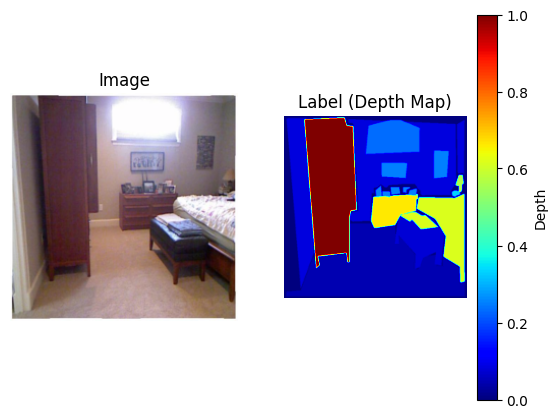

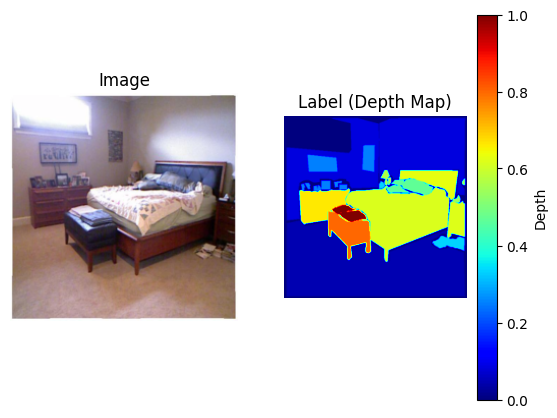

In [5]:
print(f'Number of images in the dataset: {len(dataset)}')
image, label = dataset[3]
print_image_and_label(image, label)
image, label = dataset[1448]
print_image_and_label(image, label)

## Model

Test-train split. Implemented a set seed for replicability

In [6]:
seed = 37
batch_size = 32
torch.manual_seed(seed)
np.random.seed(seed)

# Shuffle the indices of the dataset
indices = np.random.permutation(len(dataset))
shuffled_dataset = [dataset[i] for i in indices]

# Define the sizes for training, validation, and testing sets
train_size = int(0.6 * len(dataset))  # 60% of the data for training
val_size = int(0.2 * len(dataset))    # 20% of the data for validation
test_size = len(dataset) - train_size - val_size  # Remaining 20% for testing

# Split dataset into training, validation, and testing sets
train_set, val_set, test_set = random_split(shuffled_dataset, [train_size, val_size, test_size])

# Define data loaders for training, validation, and testing sets
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


#### Custom Loss Function

In the dataset, any depth value of 0 indicates that the pixel is unlabeled, not that there is 0 depth. Defiing a custom loss function to not penalize for the 0 values, but to disregard them.

In [7]:
class CustomWeightedLoss(nn.Module):
    def __init__(self):
        super(CustomWeightedLoss, self).__init__()

    def forward(self, outputs, targets):
        # Compute the absolute difference between outputs and targets
        abs_diff = torch.abs(outputs - targets)

        # Create a mask to identify where the targets are non-zero
        mask = targets != 0

        # Apply the mask to the absolute difference
        masked_abs_diff = abs_diff[mask]

        # Compute the weighted loss only for non-zero targets
        loss = torch.mean(masked_abs_diff)

        return loss

In [8]:
class ModelRunner():
    def __init__(self, train_loader, val_loader, test_loader):
        self.save_dir = 'saved_models'
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.models = {}        

    def run_model(self, model, model_name, criterion=CustomWeightedLoss(), optimizer=None, optimizer_learning_rate=0.001, num_epochs=10):
        if optimizer is None:
            optimizer = optim.Adam(model.parameters(), lr=optimizer_learning_rate)
        if model is None or model_name is None:
            raise ValueError("Must pass in a model and model name")
        lowest_loss = float('inf')
        self.models[model_name] = {'model': model, 'lowest_loss': lowest_loss}

        print(f'Starting training for {model_name}. Epochs: {num_epochs}. Learning rate: {optimizer_learning_rate}')
        for epoch in range(num_epochs):
            model.train()  
            running_loss = 0.0
            for images, labels in self.train_loader:
                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
            epoch_loss = running_loss / len(train_set)

            model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                for images, labels in self.val_loader:
                    outputs = model(images)
                    val_loss = criterion(outputs, labels)
                    running_val_loss += val_loss.item() * images.size(0)

            epoch_val_loss = running_val_loss / len(val_set)
            print(f'Epoch [{epoch+1}/{num_epochs}], \tTrain Loss: {epoch_loss:.5f}, \tValidation Loss: {epoch_val_loss:.5f}')

            # Save the model if it has a lower loss
            if epoch_val_loss < lowest_loss:
                lowest_loss = epoch_loss
                self.models[model_name]['lowest_loss'] = lowest_loss
                self.models[model_name]['model'] = model
                # Delete the old models
                for filename in os.listdir(self.save_dir):
                    if filename.startswith(model_name + '_model_epoch_') and filename.endswith('.pth'):
                        epoch_num = int(filename.split('_')[-1].split('.')[0])
                        if epoch_num < epoch + 1:
                            os.remove(os.path.join(self.save_dir, filename))
                torch.save(model.state_dict(), os.path.join(self.save_dir, model_name + f'_model_epoch_{epoch+1}.pth'))
    
    def load_model(self, model, model_name):
        latest_model_file = None
        latest_epoch = 0
        for filename in os.listdir(self.save_dir):
            if filename.startswith(model_name + '_model_epoch_') and filename.endswith('.pth'):
                epoch_num = int(filename.split('_')[-1].split('.')[0])
                if epoch_num > latest_epoch:
                    latest_epoch = epoch_num
                    latest_model_file = filename
        if latest_model_file:
            model.load_state_dict(torch.load(os.path.join(self.save_dir, latest_model_file)))
            print(f'Loaded model from {latest_model_file}')
        else:
            print('No saved model found for the specified model name.')

    def test_model(self, model, model_name, criterion=CustomWeightedLoss()):

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, depths in test_loader:
                outputs = model(images)
                test_loss += criterion(outputs, depths).item() * images.size(0)

        test_loss /= len(test_set)
        self.models[model_name]['test_loss'] = test_loss
        print(f'Val Loss: {self.models[model_name]['lowest_loss']}, \tTest Loss: {test_loss:.4f}')     
        
    def showcase(self, model, model_name):
        # Set model to evaluation mode
        model.eval()

        # Get a batch of test images and their corresponding depths
        sample_images, sample_depths = next(iter(test_loader))

        # Perform inference
        with torch.no_grad():
            outputs = model(sample_images)

        # Visualize sample outputs
        for i in range(5):
            print_image_and_label(sample_images[i], sample_depths[i], outputs[i], model_name)
model_runner = ModelRunner(train_loader, val_loader, test_loader)

### ResNet18

In [30]:
# Define depth estimation using resnet18
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.resnet = resnet18(pretrained=True)
        self.conv1 = nn.Conv2d(512, 1, kernel_size=1)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.conv1(x)
        # Upsample the output tensor to the desired size
        x = nn.functional.interpolate(x, scale_factor=32, mode='bilinear', align_corners=False)
        return x

if run_all_models:
    model_resnet18 = ResNet18()
    model_runner.run_model(model_resnet18, 'resnet18')

c:\Users\jetts\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jetts\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for resnet18. Epochs: 10. Learning rate: 0.001
Epoch [1/10], 	Train Loss: 0.74803, 	Validation Loss: 5.94713
Epoch [2/10], 	Train Loss: 0.17864, 	Validation Loss: 0.18451
Epoch [3/10], 	Train Loss: 0.16456, 	Validation Loss: 0.18318
Epoch [4/10], 	Train Loss: 0.16186, 	Validation Loss: 0.16597
Epoch [5/10], 	Train Loss: 0.15793, 	Validation Loss: 0.19135
Epoch [6/10], 	Train Loss: 0.14929, 	Validation Loss: 0.17923
Epoch [7/10], 	Train Loss: 0.14609, 	Validation Loss: 0.17968
Epoch [8/10], 	Train Loss: 0.14477, 	Validation Loss: 0.15682
Epoch [9/10], 	Train Loss: 0.14015, 	Validation Loss: 0.15396
Epoch [10/10], 	Train Loss: 0.13334, 	Validation Loss: 0.15599


Val Loss: 0.14476703373142985, 	Test Loss: 0.1454


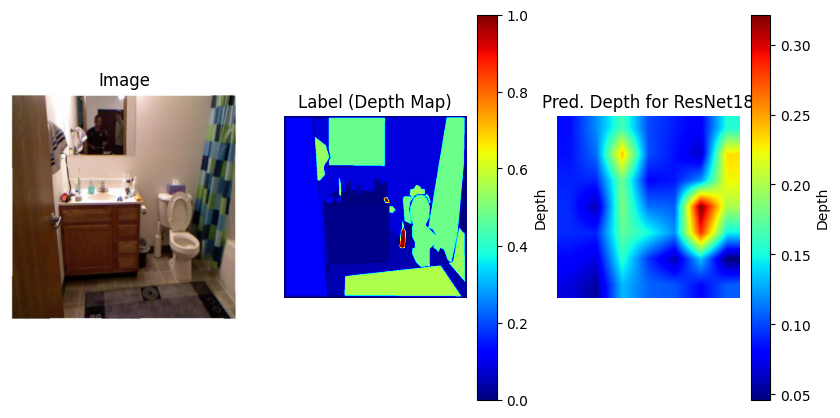

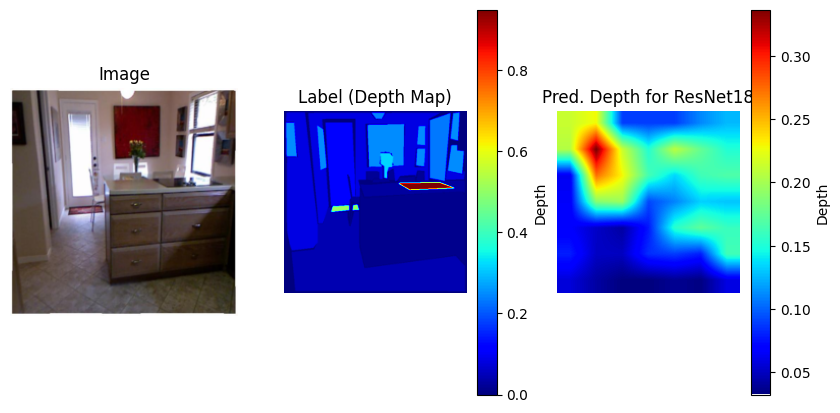

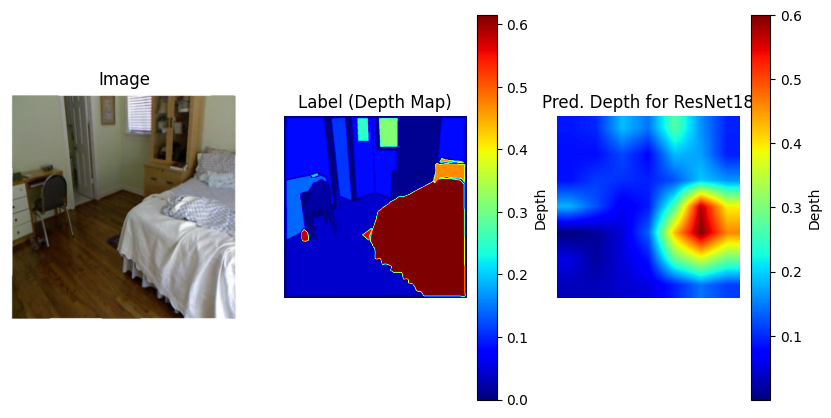

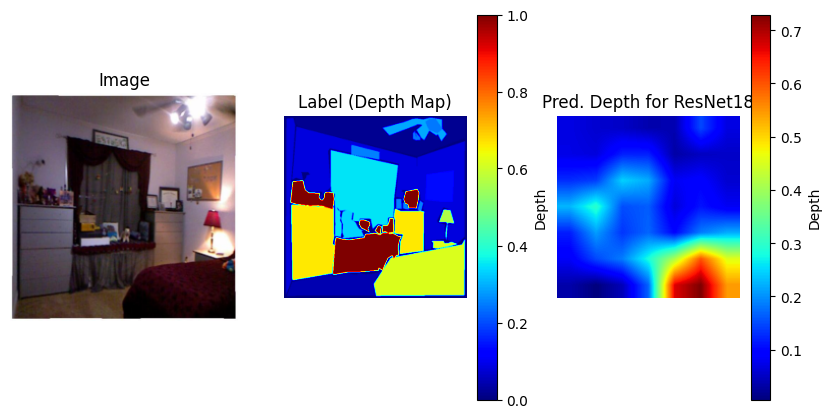

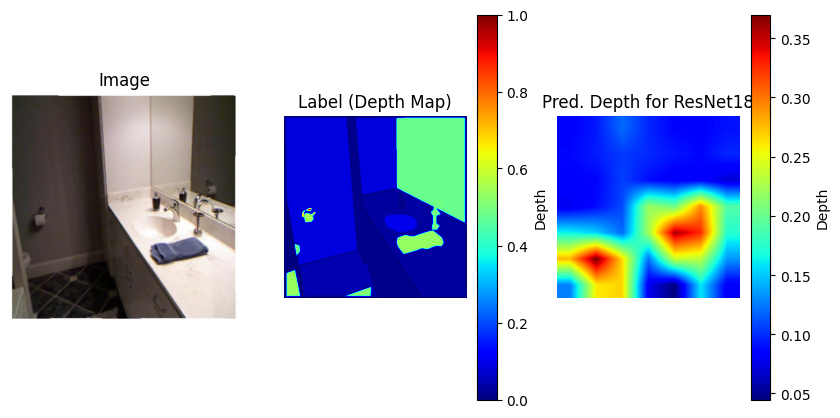

In [31]:
if 'model_resnet18' in locals():
    model_runner.test_model(model_resnet18, 'resnet18')
    model_runner.showcase(model_resnet18, 'ResNet18')

### ResNet34

In [19]:
class ResNet34(nn.Module):
    def __init__(self):
        super(ResNet34, self).__init__()
        self.resnet = resnet34(pretrained=True)
        self.conv1 = nn.Conv2d(512, 1, kernel_size=1)  # Modify based on the last layer of ResNet34

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.conv1(x)
        # Upsample the output tensor to the desired size
        x = F.interpolate(x, scale_factor=32, mode='bilinear', align_corners=False)
        return x

# Create an instance of ResNet34 model
if run_all_models:
    model_resnet34 = ResNet34()
    model_runner.run_model(model_resnet34, 'resnet34')


c:\Users\jetts\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jetts\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\jetts/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100.0%


Starting training for resnet34. Epochs: 10. Learning rate: 0.001
Epoch [1/10], 	Train Loss: 0.50243, 	Validation Loss: 6.78151
Epoch [2/10], 	Train Loss: 0.16998, 	Validation Loss: 0.18901
Epoch [3/10], 	Train Loss: 0.16111, 	Validation Loss: 0.17153
Epoch [4/10], 	Train Loss: 0.15474, 	Validation Loss: 0.15645
Epoch [5/10], 	Train Loss: 0.15941, 	Validation Loss: 0.78018
Epoch [6/10], 	Train Loss: 0.16142, 	Validation Loss: 0.15561
Epoch [7/10], 	Train Loss: 0.15033, 	Validation Loss: 0.18634
Epoch [8/10], 	Train Loss: 0.16849, 	Validation Loss: 0.23505
Epoch [9/10], 	Train Loss: 0.16372, 	Validation Loss: 0.16722
Epoch [10/10], 	Train Loss: 0.15087, 	Validation Loss: 0.14892


Val Loss: 0.15086694600187045, 	Test Loss: 0.1450


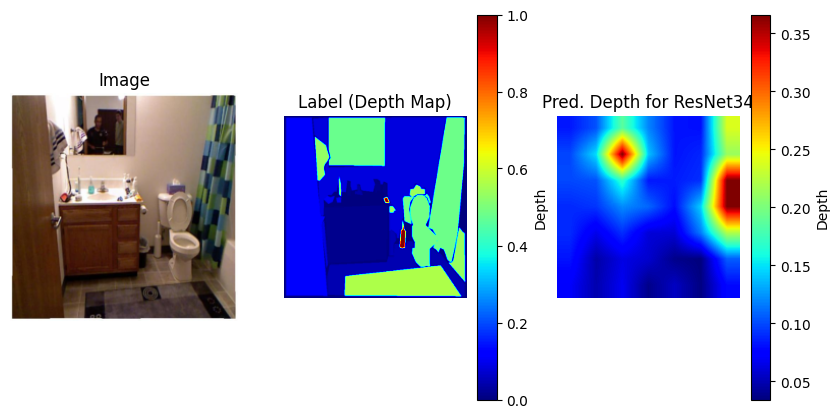

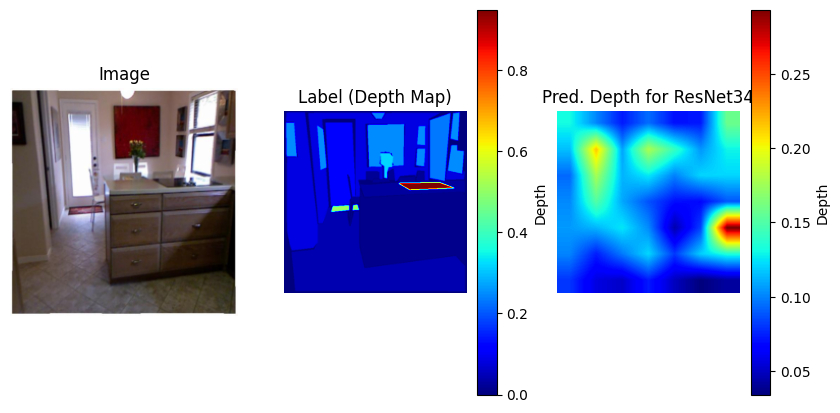

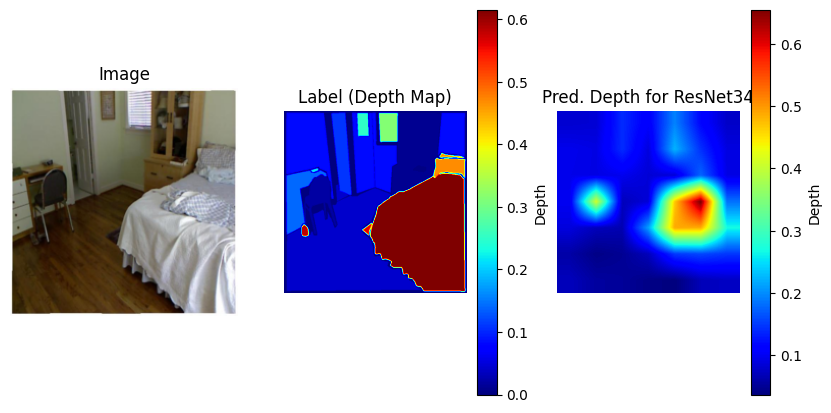

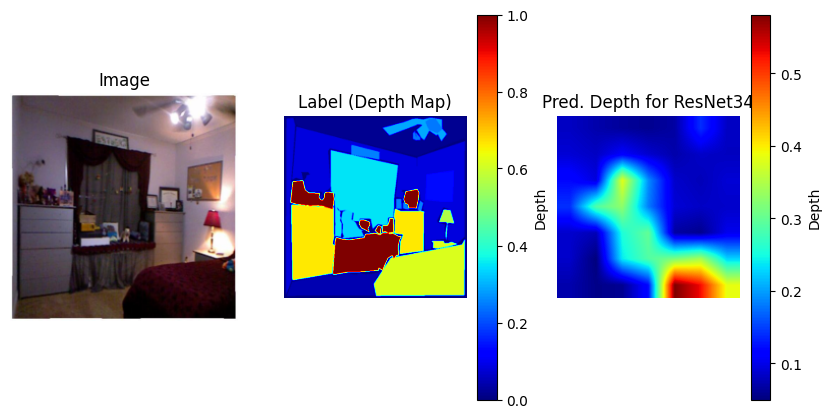

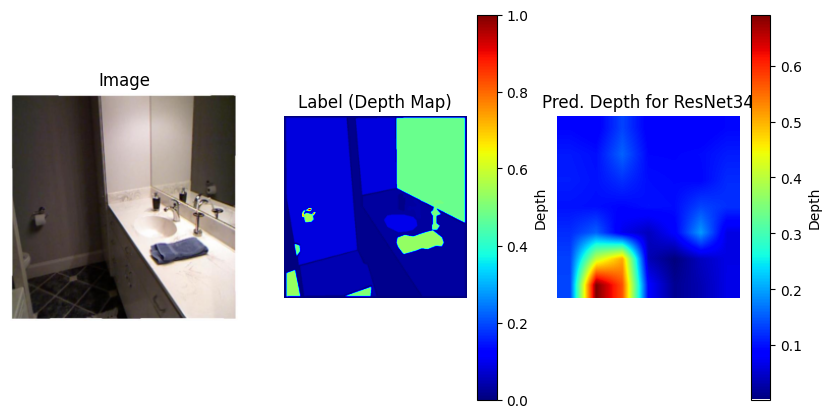

In [20]:
if 'model_resnet34' in locals():
    model_runner.test_model(model_resnet34, 'resnet34')
    model_runner.showcase(model_resnet34, 'ResNet34')

### ResNet50

In [13]:
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.resnet = resnet50(pretrained=True)
        self.conv1 = nn.Conv2d(2048, 1, kernel_size=1)  # Modify based on the last layer of ResNet50

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.conv1(x)
        # Upsample the output tensor to the desired size
        x = F.interpolate(x, scale_factor=32, mode='bilinear', align_corners=False)
        return x

# Create an instance of ResNet50 model
if run_all_models:
    model_resnet50 = ResNet50()
    model_runner.run_model(model_resnet50, 'resnet50')

c:\Users\jetts\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jetts\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for resnet50. Epochs: 10. Learning rate: 0.001
Epoch [1/10], 	Train Loss: 0.37796, 	Validation Loss: 0.17166
Epoch [2/10], 	Train Loss: 0.17881, 	Validation Loss: 0.24370
Epoch [3/10], 	Train Loss: 0.17305, 	Validation Loss: 0.22514
Epoch [4/10], 	Train Loss: 0.15616, 	Validation Loss: 0.15640
Epoch [5/10], 	Train Loss: 0.14827, 	Validation Loss: 0.32269
Epoch [6/10], 	Train Loss: 0.15468, 	Validation Loss: 0.16019
Epoch [7/10], 	Train Loss: 0.14743, 	Validation Loss: 0.16022
Epoch [8/10], 	Train Loss: 0.13893, 	Validation Loss: 0.17710
Epoch [9/10], 	Train Loss: 0.13714, 	Validation Loss: 0.32837
Epoch [10/10], 	Train Loss: 0.13076, 	Validation Loss: 0.14677


Val Loss: 0.13075980614394944, 	Test Loss: 0.1393


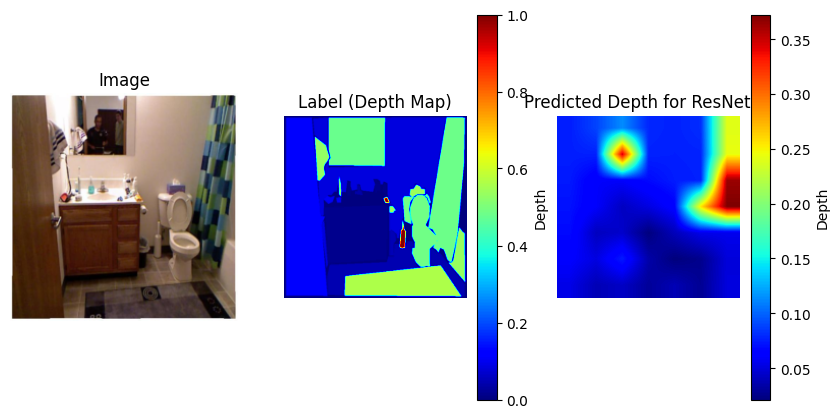

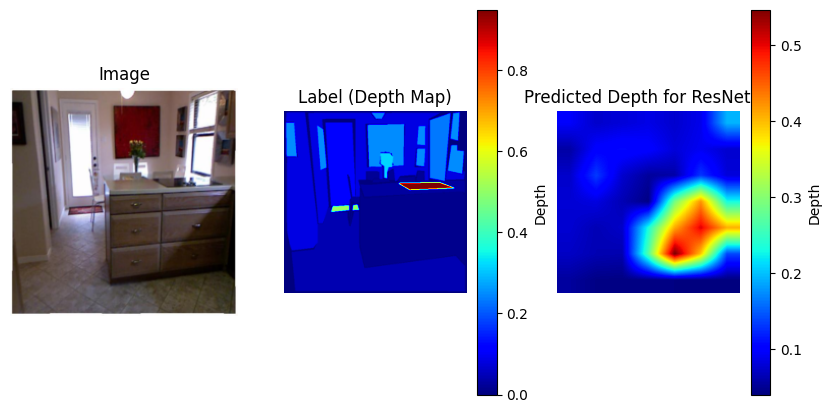

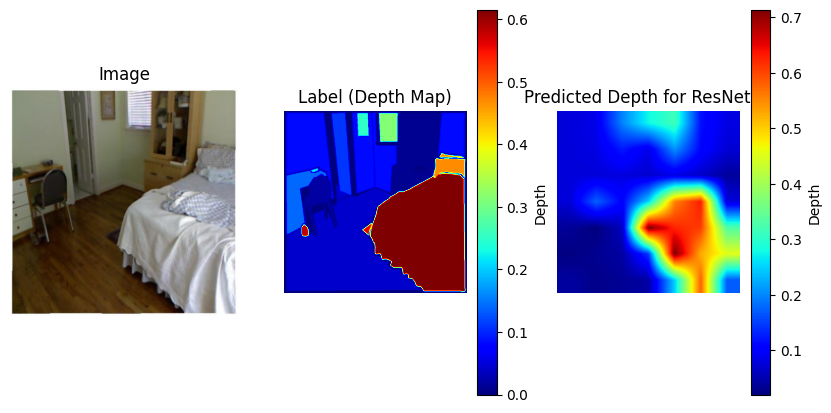

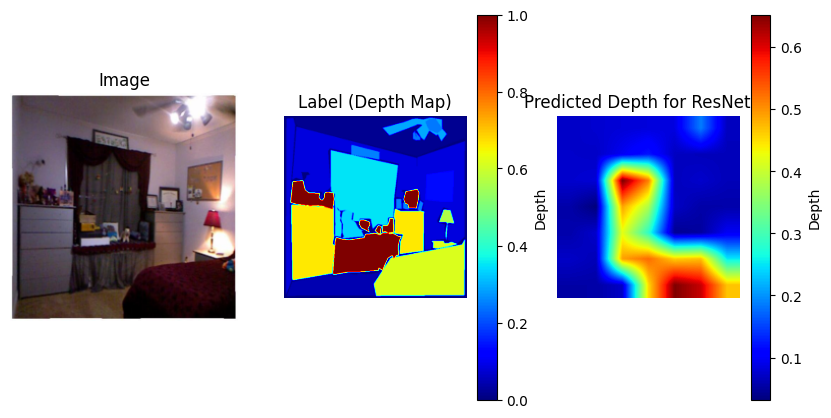

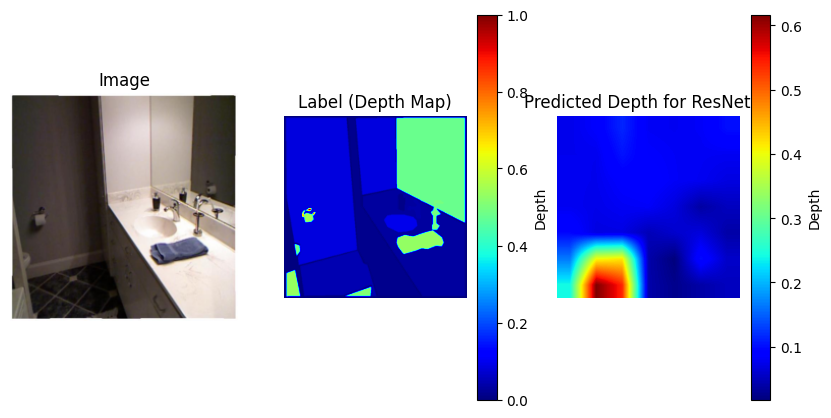

In [16]:
if 'model_resnet50' in locals():
    model_runner.test_model(model_resnet50, 'resnet50')
    model_runner.showcase(model_resnet50, 'ResNet50')

### ResNet101

In [24]:
class ResNet101(nn.Module):
    def __init__(self):
        super(ResNet101, self).__init__()
        self.resnet = resnet101(pretrained=True)
        self.conv1 = nn.Conv2d(2048, 1, kernel_size=1)  # Modify based on the last layer of ResNet101

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.conv1(x)
        # Upsample the output tensor to the desired size
        x = F.interpolate(x, scale_factor=32, mode='bilinear', align_corners=False)
        return x

# Create an instance of ResNet101 model
if run_all_models:
    model_resnet101 = ResNet101()
    model_runner.run_model(model_resnet101, 'resnet101')

c:\Users\jetts\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jetts\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\jetts/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth
100.0%


Starting training for resnet101. Epochs: 10. Learning rate: 0.001
Epoch [1/10], 	Train Loss: 0.37543, 	Validation Loss: 299.53947
Epoch [2/10], 	Train Loss: 0.16553, 	Validation Loss: 0.16584
Epoch [3/10], 	Train Loss: 0.15844, 	Validation Loss: 0.15339
Epoch [4/10], 	Train Loss: 0.15318, 	Validation Loss: 0.15207
Epoch [5/10], 	Train Loss: 0.15717, 	Validation Loss: 0.16099
Epoch [6/10], 	Train Loss: 0.15863, 	Validation Loss: 0.27804
Epoch [7/10], 	Train Loss: 0.15215, 	Validation Loss: 0.42842
Epoch [8/10], 	Train Loss: 0.14709, 	Validation Loss: 0.21188
Epoch [9/10], 	Train Loss: 0.14448, 	Validation Loss: 0.15452
Epoch [10/10], 	Train Loss: 0.15057, 	Validation Loss: 0.15983


Val Loss: 0.1531833139332858, 	Test Loss: 0.1515


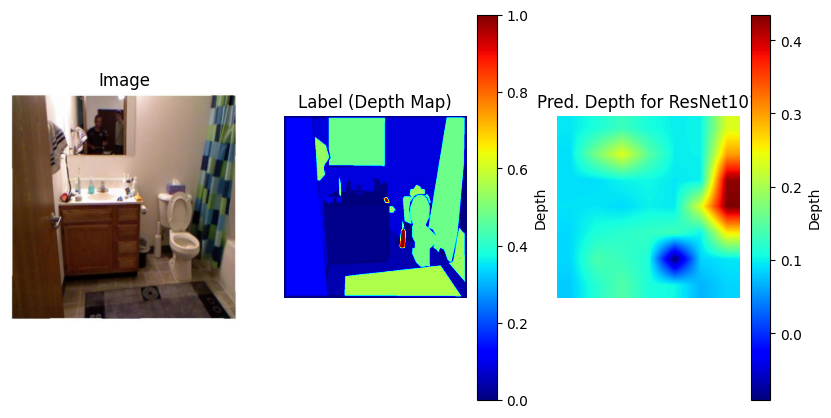

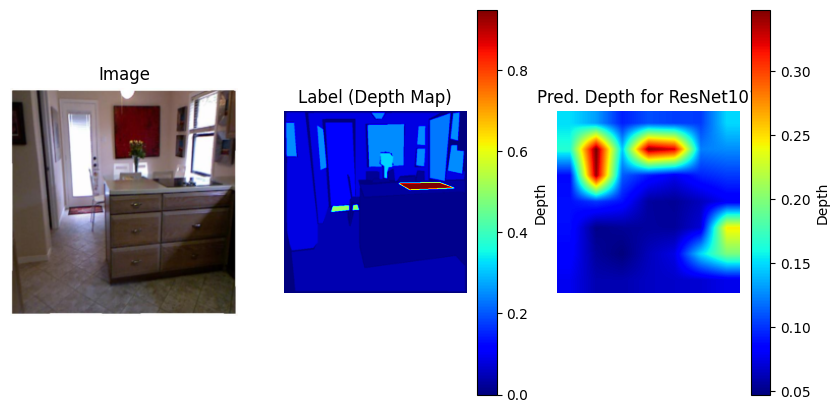

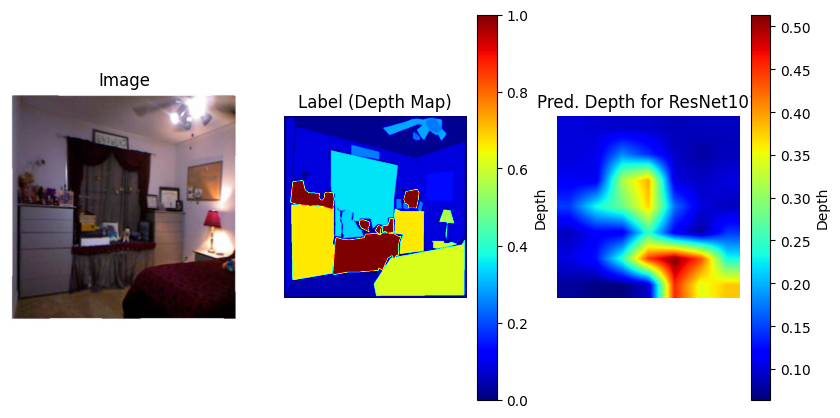

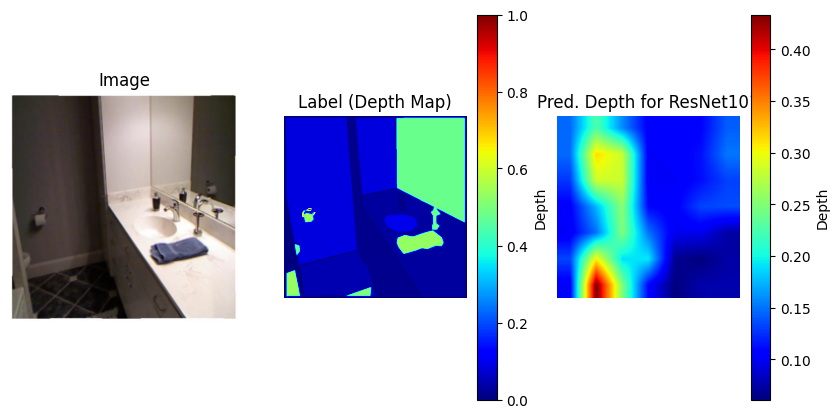

In [25]:
if 'model_resnet101' in locals():
    model_runner.test_model(model_resnet101, 'resnet101')
    model_runner.showcase(model_resnet101, 'ResNet101')

### ResNet152

In [27]:
class ResNet152(nn.Module):
    def __init__(self):
        super(ResNet152, self).__init__()
        self.resnet = resnet152(pretrained=True)
        self.conv1 = nn.Conv2d(2048, 1, kernel_size=1)  # Modify based on the last layer of ResNet152

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.conv1(x)
        # Upsample the output tensor to the desired size
        x = F.interpolate(x, scale_factor=32, mode='bilinear', align_corners=False)
        return x

# Create an instance of ResNet152 model
if run_all_models or True:
    model_resnet152 = ResNet152()
    model_runner.run_model(model_resnet152, 'resnet152')


c:\Users\jetts\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to C:\Users\jetts/.cache\torch\hub\checkpoints\resnet152-394f9c45.pth
100.0%


Starting training for resnet152. Epochs: 10. Learning rate: 0.001
Epoch [1/10], 	Train Loss: 0.46869, 	Validation Loss: 28.98595
Epoch [2/10], 	Train Loss: 0.18118, 	Validation Loss: 11.76146
Epoch [3/10], 	Train Loss: 0.16646, 	Validation Loss: 0.27258
Epoch [4/10], 	Train Loss: 0.16253, 	Validation Loss: 0.16871
Epoch [5/10], 	Train Loss: 0.16741, 	Validation Loss: 0.56230
Epoch [6/10], 	Train Loss: 0.16564, 	Validation Loss: 34.49067
Epoch [7/10], 	Train Loss: 0.16472, 	Validation Loss: 1.59110
Epoch [8/10], 	Train Loss: 0.16936, 	Validation Loss: 0.60035
Epoch [9/10], 	Train Loss: 0.16488, 	Validation Loss: 0.16683
Epoch [10/10], 	Train Loss: 0.16708, 	Validation Loss: 0.19612


Val Loss: 0.16645759224068585, 	Test Loss: 0.1827


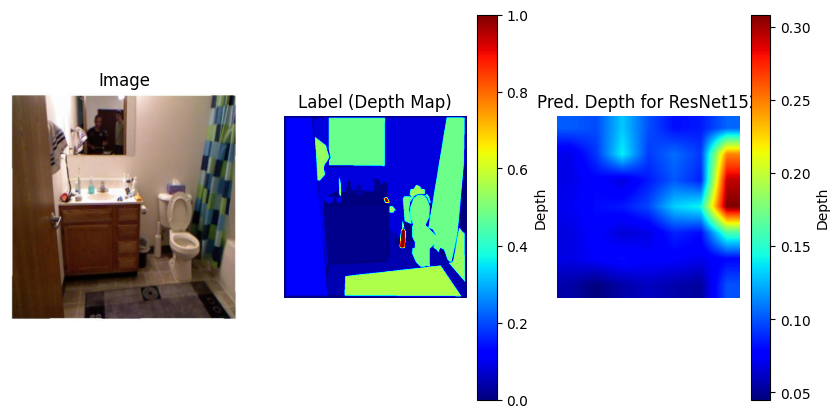

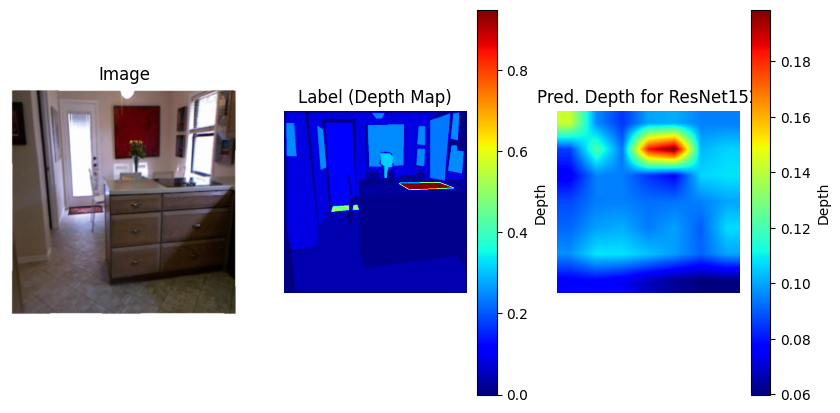

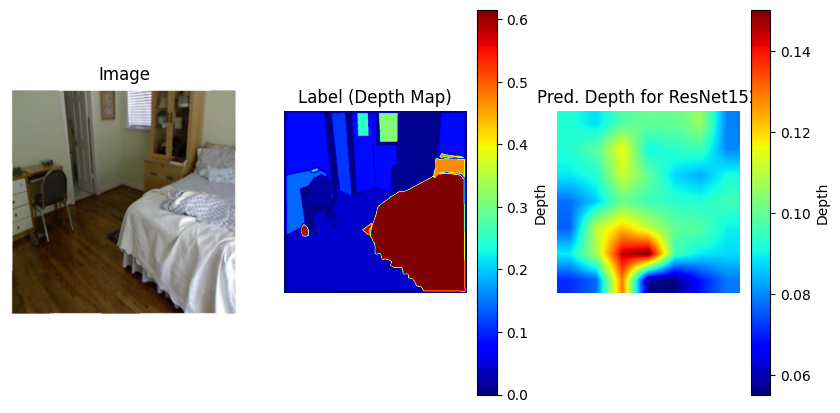

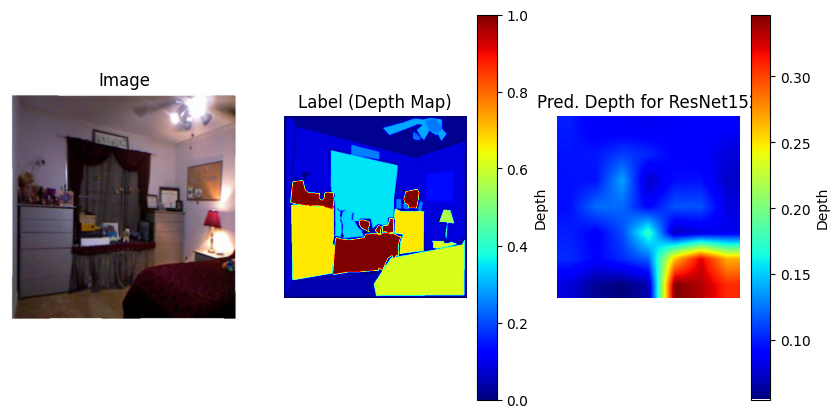

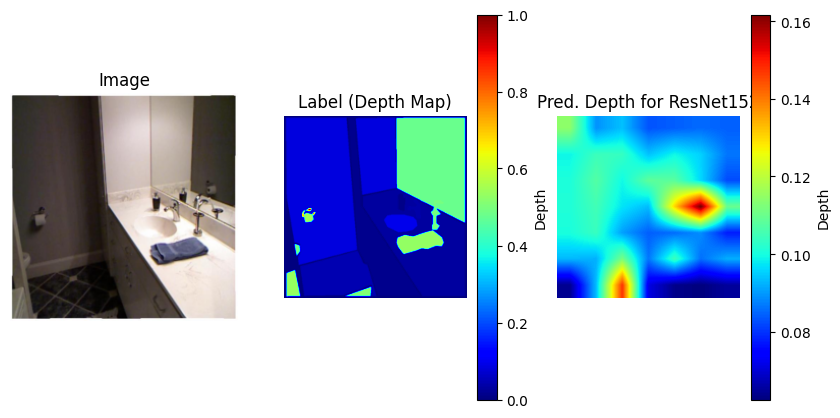

In [28]:
if 'model_resnet152' in locals():
    model_runner.test_model(model_resnet152, 'resnet152')
    model_runner.showcase(model_resnet152, 'ResNet152')